In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

In [3]:
dataset = pd.read_csv('car_data.csv')
print(dataset.shape)

dataset.head()

(1000, 5)


,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [4]:
dataset.drop(['User ID'], axis = 1, inplace = True)

dataset.head()

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


# The Variable Types

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Gender        1000 non-null   object
 1   Age           1000 non-null   int64 
 2   AnnualSalary  1000 non-null   int64 
 3   Purchased     1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [6]:
dataset['Purchased'] = dataset['Purchased'].astype('object')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Gender        1000 non-null   object
 1   Age           1000 non-null   int64 
 2   AnnualSalary  1000 non-null   int64 
 3   Purchased     1000 non-null   object
dtypes: int64(2), object(2)
memory usage: 31.4+ KB


## Numerical Features

In [7]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtype != 'object']
print("Total number of numerical features: ", len(numerical_features))

print(numerical_features)

Total number of numerical features:  2
['Age', 'AnnualSalary']


In [8]:
categorical_features = [feature for feature in dataset.columns if dataset[feature].dtype == 'O' and feature != 'Purchased']
print('Total number of categorical features: ', len(categorical_features))

print(categorical_features)

Total number of categorical features:  1
['Gender']


# Splitting the dataset

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset.drop(['Purchased'], axis = 1), dataset['Purchased'], test_size = 0.3, random_state = 909)

# Numerical Feature Transformation

## AnnualSalary

In [10]:
from feature_engine.transformation import YeoJohnsonTransformer

yeojohnson_transformer = YeoJohnsonTransformer(variables = ['AnnualSalary'])
yeojohnson_transformer.fit(X_train, y_train)

X_train = yeojohnson_transformer.transform(X_train)
X_test = yeojohnson_transformer.transform(X_test)

In [11]:
X_train.head()

,Gender,Age,AnnualSalary
291,Male,57,379.850483
750,Male,34,510.767476
728,Male,41,409.279771
631,Female,26,350.833133
68,Male,41,327.604416


# Categorical Encoding

## Gender

In [12]:
from feature_engine.encoding import OneHotEncoder

encode_gender = OneHotEncoder(drop_last = True, variables = ['Gender'])
encode_gender.fit(X_train, y_train)

X_train = encode_gender.transform(X_train)
X_test = encode_gender.transform(X_test)

In [13]:
X_train.head()

,Age,AnnualSalary,Gender_Male
291,57,379.850483,1
750,34,510.767476,1
728,41,409.279771,1
631,26,350.833133,0
68,41,327.604416,1


# Feature Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train, y_train)

columns = list(X_train.columns)

X_train = pd.DataFrame(scaler.transform(X_train), columns = columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = columns)

y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [15]:
X_train.head()

,Age,AnnualSalary,Gender_Male
0,0.866667,0.476359,1.0
1,0.355556,0.812714,1.0
2,0.511111,0.551970,1.0
3,0.177778,0.401808,0.0
4,0.511111,0.342128,1.0


In [16]:
y_train.head()

0    1
1    0
2    0
3    0
4    0
Name: Purchased, dtype: object

# Encoding and Decoding fns for target feature

In [17]:
def target_encode(value):
    target_dict = {0: 'Not_Purchased', 1: 'Purchased'}
    
    return target_dict[value]

In [18]:
y_train = y_train.apply(target_encode)
y_test = y_test.apply(target_encode)

In [19]:
y_train.head()

0        Purchased
1    Not_Purchased
2    Not_Purchased
3    Not_Purchased
4    Not_Purchased
Name: Purchased, dtype: object

In [20]:
def target_decode(value):
    target_dict = {'Not_Purchased': 0, 'Purchased': 1}
    
    return target_dict[value]

In [21]:
features = list(X_train.columns)

# Models

## Logistic Regression

In [22]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(C = 1/0.001)
classifier.fit(X_train, y_train)

LogisticRegression(C=1000.0)

In [23]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
import pandas as pd

def print_metrics(y_train_pred, y_test_pred):
    print()
    
    print("Train set accuracy_score: ", accuracy_score(y_train, y_train_pred))
    print("Test set accuracy_score: ", accuracy_score(y_test, y_test_pred))
    
    print("-----------------------------------------------------------------------------------------------------------------------")
    
    print("Train set classification_report: \n\n", classification_report(y_train, y_train_pred))
    print()
    print("Test set classification_report: \n\n", classification_report(y_test, y_test_pred))

    print("-----------------------------------------------------------------------------------------------------------------------")
    
    print("Train set roc_auc_score: ", roc_auc_score(y_train.apply(target_decode), pd.Series(y_train_pred).apply(target_decode)))
    print("Test set roc_auc_score: ", roc_auc_score(y_test.apply(target_decode), pd.Series(y_test_pred).apply(target_decode)))
    
    print("-----------------------------------------------------------------------------------------------------------------------")
    
    print("Train set confusion_matrix: \n\n", confusion_matrix(y_train, y_train_pred))
    print()
    print("Test set confusion_matrix: \n\n", confusion_matrix(y_test, y_test_pred))


In [25]:
print_metrics(y_train_pred, y_test_pred)


Train set accuracy_score:  0.8285714285714286
Test set accuracy_score:  0.7966666666666666
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.83      0.90      0.87       427
    Purchased       0.82      0.71      0.76       273

     accuracy                           0.83       700
    macro avg       0.83      0.81      0.81       700
 weighted avg       0.83      0.83      0.83       700


Test set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.79      0.88      0.83       171
    Purchased       0.81      0.69      0.74       129

     accuracy                           0.80       300
    macro avg       0.80      0.78      0.79       300
 weighted avg       0.80      0.80      0.79       300

--------------------------------------------------

### Important Features

In [26]:
import matplotlib.pyplot as plt

def feature_importance(classifier):
    
    important_features = pd.Series(sorted(classifier.coef_.ravel()))
    important_features.sort_values(ascending = False, inplace = True)
    important_features.index = features

    important_features.plot.bar()
    
    plt.ylabel('Coefficients')
    plt.title('Feature Importance')

    plt.show()

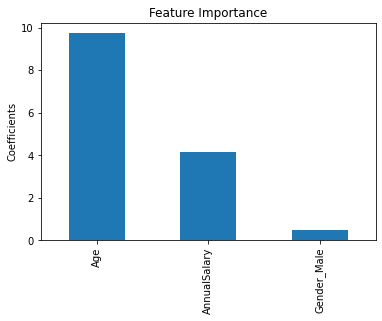

In [27]:
feature_importance(classifier)

## XGBoost (0.99, 0.89)

In [28]:
from xgboost import XGBClassifier

classifier = XGBClassifier(use_label_encoder = False, eval_metric = 'mlogloss')
classifier.fit(X_train, y_train.apply(target_decode))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [29]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

In [30]:
print_metrics(pd.Series(y_train_pred).apply(target_encode), pd.Series(y_test_pred).apply(target_encode))


Train set accuracy_score:  0.9942857142857143
Test set accuracy_score:  0.89
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.99      1.00      1.00       427
    Purchased       1.00      0.99      0.99       273

     accuracy                           0.99       700
    macro avg       1.00      0.99      0.99       700
 weighted avg       0.99      0.99      0.99       700


Test set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.92      0.89      0.90       171
    Purchased       0.86      0.89      0.87       129

     accuracy                           0.89       300
    macro avg       0.89      0.89      0.89       300
 weighted avg       0.89      0.89      0.89       300

----------------------------------------------------------------

## RandomForest 

In [31]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [32]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

print_metrics(pd.Series(y_train_pred), pd.Series(y_test_pred))


Train set accuracy_score:  0.9842857142857143
Test set accuracy_score:  0.8833333333333333
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.98      0.99      0.99       427
    Purchased       0.99      0.97      0.98       273

     accuracy                           0.98       700
    macro avg       0.99      0.98      0.98       700
 weighted avg       0.98      0.98      0.98       700


Test set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.89      0.91      0.90       171
    Purchased       0.88      0.84      0.86       129

     accuracy                           0.88       300
    macro avg       0.88      0.88      0.88       300
 weighted avg       0.88      0.88      0.88       300

--------------------------------------------------

## KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [34]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

print_metrics(pd.Series(y_train_pred), pd.Series(y_test_pred))


Train set accuracy_score:  0.9371428571428572
Test set accuracy_score:  0.8933333333333333
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.95      0.95      0.95       427
    Purchased       0.92      0.92      0.92       273

     accuracy                           0.94       700
    macro avg       0.93      0.93      0.93       700
 weighted avg       0.94      0.94      0.94       700


Test set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.90      0.91      0.91       171
    Purchased       0.88      0.87      0.88       129

     accuracy                           0.89       300
    macro avg       0.89      0.89      0.89       300
 weighted avg       0.89      0.89      0.89       300

--------------------------------------------------

C:\Users\neere\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\neere\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated,

## Navie Bayes


In [35]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [36]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

print_metrics(pd.Series(y_train_pred), pd.Series(y_test_pred))


Train set accuracy_score:  0.8742857142857143
Test set accuracy_score:  0.86
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.88      0.91      0.90       427
    Purchased       0.86      0.81      0.83       273

     accuracy                           0.87       700
    macro avg       0.87      0.86      0.87       700
 weighted avg       0.87      0.87      0.87       700


Test set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.85      0.92      0.88       171
    Purchased       0.88      0.78      0.83       129

     accuracy                           0.86       300
    macro avg       0.86      0.85      0.85       300
 weighted avg       0.86      0.86      0.86       300

----------------------------------------------------------------

## SVC

In [37]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [38]:
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

print_metrics(pd.Series(y_train_pred), pd.Series(y_test_pred))


Train set accuracy_score:  0.9014285714285715
Test set accuracy_score:  0.8966666666666666
-----------------------------------------------------------------------------------------------------------------------
Train set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.93      0.91      0.92       427
    Purchased       0.86      0.89      0.88       273

     accuracy                           0.90       700
    macro avg       0.89      0.90      0.90       700
 weighted avg       0.90      0.90      0.90       700


Test set classification_report: 

                precision    recall  f1-score   support

Not_Purchased       0.90      0.92      0.91       171
    Purchased       0.90      0.86      0.88       129

     accuracy                           0.90       300
    macro avg       0.90      0.89      0.89       300
 weighted avg       0.90      0.90      0.90       300

--------------------------------------------------